In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.vgg1 import VGG16, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
# print(train_datagen)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('C:/Users/arunn/Desktop/data/train_image',
target_size = (256,256),
batch_size = 32,
class_mode = 'binary')
# print(test_datagen)
test_set = test_datagen.flow_from_directory('C:/Users/arunn/Desktop/data/test_image',
target_size = (256,256),
batch_size = 32,
class_mode = 'binary')

Found 400 images belonging to 2 classes.
Found 201 images belonging to 2 classes.


In [3]:
pre_trained_model = VGG16(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
# loading the VGG16 model to tarin

In [4]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))
#frezing the all layers of VGG16 model

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19


In [5]:
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 8, 8, 512)


In [6]:
#fine tune the last layer
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)
# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=True)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [8]:
batch_size=20
model_info=model.fit_generator(training_set,
steps_per_epoch = 400/batch_size,
epochs = 3,
validation_data = test_set,
validation_steps = 2/batch_size)

Epoch 1/3
20/20 [==============================] - 288s 14s/step - loss: 0.7318 - accuracy: 0.5312 - val_loss: 0.6826 - val_accuracy: 0.5625
Epoch 2/3
20/20 [==============================] - 272s 14s/step - loss: 0.7121 - accuracy: 0.5321 - val_loss: 0.6417 - val_accuracy: 0.7812
Epoch 3/3
20/20 [==============================] - 249s 12s/step - loss: 0.6766 - accuracy: 0.5905 - val_loss: 0.6411 - val_accuracy: 0.8125


In [9]:
### Performance evaluation
#########################
score = model.evaluate_generator(test_set,40/batch_size)
print(" Total: ", len(test_set.filenames))
print("Loss: ", score[0], "Accuracy: ", score[1])
#print("Accuracy = ",score[1])

 Total:  201
Loss:  0.6026865243911743 Accuracy:  0.8125


## fine tune the layers

In [10]:
for layer in model.layers[:15]:
    layer.trainable = False

for layer in model.layers[15:]:
    layer.trainable = True

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

In [16]:
batch_size=40
model_info=model.fit_generator(training_set,
steps_per_epoch = 400/batch_size,
epochs = 20,
validation_data = test_set,
validation_steps = 30/batch_size,
callbacks=[learning_rate_reduction])

Epoch 1/20
10/10 [==============================] - 132s 13s/step - loss: 0.4783 - accuracy: 0.8158 - val_loss: 0.5485 - val_accuracy: 0.6875
Epoch 2/20
10/10 [==============================] - 131s 13s/step - loss: 0.4773 - accuracy: 0.8191 - val_loss: 0.4380 - val_accuracy: 0.9688
Epoch 3/20
10/10 [==============================] - 136s 14s/step - loss: 0.4755 - accuracy: 0.7750 - val_loss: 0.4607 - val_accuracy: 0.9062
Epoch 4/20
10/10 [==============================] - 129s 13s/step - loss: 0.4814 - accuracy: 0.7796 - val_loss: 0.5172 - val_accuracy: 0.8438
Epoch 5/20
10/10 [==============================] - 128s 13s/step - loss: 0.4706 - accuracy: 0.8026 - val_loss: 0.5600 - val_accuracy: 0.7812
Epoch 6/20
10/10 [==============================] - 138s 14s/step - loss: 0.4624 - accuracy: 0.8313 - val_loss: 0.4878 - val_accuracy: 0.9062
Epoch 7/20
10/10 [==============================] - 121s 12s/step - loss: 0.4874 - accuracy: 0.8026 - val_loss: 0.4833 - val_accuracy: 0.8889
Epoch 

In [17]:
### Performance evaluation
#########################
score = model.evaluate_generator(test_set,20/batch_size)
print(" Total: ", len(test_set.filenames))
print("Loss: ", score[0], "Accuracy: ", score[1])
#print("Accuracy = ",score[1])

 Total:  201
Loss:  0.4543827772140503 Accuracy:  0.90625


Text(0.5, 1.0, 'Training and validation loss')

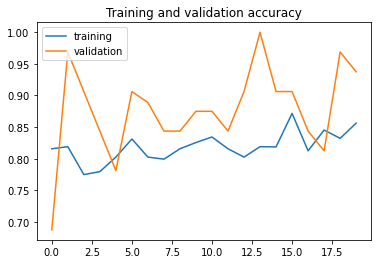

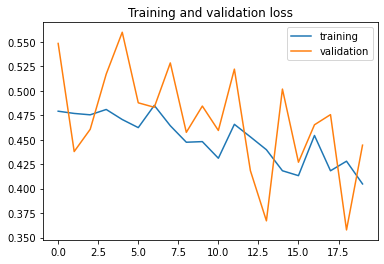

In [18]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = model_info.history['accuracy']
val_acc = model_info.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = model_info.history['loss']
val_loss = model_info.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

 Glaucoma


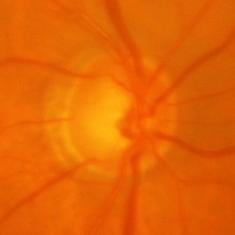

In [19]:
import numpy as np
from PIL import Image
from keras.preprocessing import image
test_image = image.load_img(r'C:\Users\arunn\Desktop\data\test_image\glucoma\Im427_g_ACRIMA.jpg', target_size = (256,256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
 print("not Glaucoma")
else:
 print(" Glaucoma")
display(Image.open(r'C:\Users\arunn\Desktop\data\test_image\glucoma\Im427_g_ACRIMA.jpg'))

# Saving the model

In [20]:
model.save('VGG16_train_model_glucoma.h5')

# confusion matrix

In [30]:
from sklearn.metrics import confusion_matrix,classification_report
Y_pred = model.predict_generator(test_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = ['glucoma','not glucoma']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Confusion Matrix
[[101   0]
 [100   0]]
Classification Report
              precision    recall  f1-score   support

     glucoma       0.50      1.00      0.67       101
 not glucoma       0.00      0.00      0.00       100

    accuracy                           0.50       201
   macro avg       0.25      0.50      0.33       201
weighted avg       0.25      0.50      0.34       201



C:\annaconda\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

# ploat the labels

In [32]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [41]:
T_set= ImageDataGenerator().flow_from_directory(r'C:\Users\arunn\Desktop\data\MY_test\validation_image',classes=['glaucoma','healthy'], target_size=(224,224), batch_size=10)

Found 32 images belonging to 2 classes.


C:\annaconda\envs\tensorflow_env\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


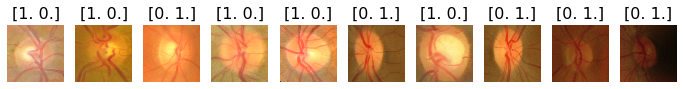

In [42]:
imgs, labels = next(T_set)
plots(imgs, titles=labels)